# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [39]:
# import libraries
%matplotlib inline
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


In [31]:
import re
from matplotlib import pyplot as plt
import seaborn as sns

sns.set_style("ticks")
sns.set_color_codes()
sns.set(font_scale=1)

from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import pyspark.sql.types as pysTypes

from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler, MinMaxScaler, PCA
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder


In [32]:
# create a Spark session

spark = SparkSession.builder.appName("Udacity Sparkify Project").getOrCreate()
spark.conf.set("spark.sql.crossJoin.enabled", "true")

### <span style="color:blue">Porblem Definition and Solution Strategies</span>
* **Problem Definition**
    * some users after using the music app churn meaning either downgrade or cancel their membership 
    * our goals is to identify this user and offer them attractive packages not to lose them
    * This history of these users interaction is provided as the dataset
    * this data contains unique user ids and a list of songs each listens to and their interaction with various pages 
* **Solution Strategies**
    * clean the dataset and remove duplicated and null data
    * label data and identify churn event based on the "Cancellation Confirmation"
    * explanatory data visualization for understanding data and its relation to churn events
    * generate features based on observation of the raw data
    * scaled features and normalize them
    * select various classification algorithm and study their performance 

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [29]:
data_path = 'mini_sparkify_event_data.json'
df_raw = spark.read.json(data_path)
df_raw.describe().show()


+-------+------------------+----------+---------+------+------------------+--------+-----------------+------+-----------------+------+-------+--------------------+-----------------+--------------------+------------------+--------------------+--------------------+-----------------+
|summary|            artist|      auth|firstName|gender|     itemInSession|lastName|           length| level|         location|method|   page|        registration|        sessionId|                song|            status|                  ts|           userAgent|           userId|
+-------+------------------+----------+---------+------+------------------+--------+-----------------+------+-----------------+------+-------+--------------------+-----------------+--------------------+------------------+--------------------+--------------------+-----------------+
|  count|            228108|    286500|   278154|278154|            286500|  278154|           228108|286500|           278154|286500| 286500|            

In [5]:
# Pandas has more readable printout :)
df_raw.sample(False, 0.00005, 42).toPandas()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Peter Cetera,Logged In,Nicole,F,225,Beck,262.53016,paid,"Vineland-Bridgeton, NJ",PUT,NextSong,1532224335000,420,Glory Of Love [Theme From The Karate Kid Part II],200,1538699101000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",124
1,A Perfect Circle,Logged In,Dillyn,F,107,Richardson,195.18649,paid,"Danville, VA",PUT,NextSong,1537811988000,1062,Weak And Powerless,200,1540076582000,"""Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537....",42
2,Katie Melua,Logged In,Dillyn,F,17,Richardson,208.53506,paid,"Danville, VA",PUT,NextSong,1537811988000,1118,Shy Boy,200,1540228380000,"""Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537....",42
3,Will Young,Logged In,Alyssa,F,59,Johnston,207.90812,free,"Los Angeles-Long Beach-Anaheim, CA",PUT,NextSong,1532634173000,1169,Light My Fire,200,1540440708000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,66
4,Alicia Keys,Logged In,Sadie,F,96,Jones,253.12608,paid,"Denver-Aurora-Lakewood, CO",PUT,NextSong,1537054553000,1569,Like The Sea,200,1541450810000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",132
5,Coldplay,Logged In,Kimberly,F,78,Norton,228.77995,paid,"Washington-Arlington-Alexandria, DC-VA-MD-WV",PUT,NextSong,1538215963000,1688,In My Place,200,1542090866000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",108
6,Slim Whitman,Logged In,Miracle,F,67,Ho,142.83710,paid,"Atlanta-Sandy Springs-Roswell, GA",PUT,NextSong,1534613601000,1732,Cattle Call,200,1542334155000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,52
7,Rosana,Logged In,Freedom,F,15,Aguilar,183.11791,paid,"Charlotte-Concord-Gastonia, NC-SC",PUT,NextSong,1537034286000,1938,Furia de color,200,1542672528000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",136
8,Eiffel 65,Logged In,Carly,F,127,Weiss,285.93587,paid,"Minneapolis-St. Paul-Bloomington, MN-WI",PUT,NextSong,1533908361000,1898,Blue (Da Ba Dee),200,1542689680000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",36
9,BeBe Winans_ CeCe Winans,Logged In,Riley,F,27,Stewart,202.08281,free,"Los Angeles-Long Beach-Anaheim, CA",PUT,NextSong,1536963671000,286,Close to You,200,1541403933000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_2...",200006


In [5]:
def cleanse_numericals_and_categoricals(df):
    """
    :param df: Spark Dataframe
    :return df: Spark Dataframe
    """
    print("\n number missing values for each column")
    df.select([F.count(F.when(F.isnan(c) | F.col(c).isNull() | (F.length(c)==0), c)).alias(c) for c in df.columns]).show()
    print("\n size before clean up:{}".format(df.count()))
    df = df.dropDuplicates()
    df = df.filter(F.col("userId")!="")  
    
    print("\n Add user device")
    user_devices = {"Windows":"Windows", "iPad":"iPad", "iPhone":"iPhone", "Macintosh":"Machintosh", "compatible":"Windows", "X11":"Linux"}
    regs = F.udf(lambda x: user_devices[re.findall(r"\(\w*",x)[0][1:]])
    df = df.withColumn("userDevice", regs(F.col("userAgent")))
    
    print("\n size after clean up:{}".format(df.count()))
    print("\n notice removing missing values from  [userId] also cleans up other columns such as [firstName, gender, lastName, location, registration, userAgent] ")
    df.select([F.count(F.when(F.isnan(c) | F.col(c).isNull() | (F.length(c)==0) ,c)).alias(c) for c in df.columns]).show()
    
    print("\n cast userId type to long")
    df = df.withColumn("userId", F.col("userId").cast(pysTypes.LongType()))    
    
    print("\n generate month, monthDay, hour, weekDay from ts")
    df = df.withColumn("month", F.month(F.from_unixtime(F.col("ts")*0.001).cast(pysTypes.DateType())))
    df = df.withColumn("monthDay", F.dayofmonth(F.from_unixtime(F.col("ts")*0.001).cast(pysTypes.DateType())))
    df = df.withColumn("hour", F.hour(F.from_unixtime(F.col("ts")*0.001))) 
    df = df.withColumn("weekDay", F.dayofweek(F.from_unixtime(F.col("ts")*0.001)))
    df = df.withColumn("date", F.from_unixtime(F.col("ts")*0.001).cast(pysTypes.DateType()))
    
    print("\n generate from location value with only the name of the state")
    df = df.withColumn("location", F.split(F.col("location"),",").getItem(1))  
    
    print("\n there is no NextPage event with length ==0")
    df.filter("page == 'NextSong'").filter(F.isnan("length") | F.col("length").isNull() | (F.length("length")==0)).show()
    
    print("\n fill all nan values for [artist, length, song] with zero")
    df = df.fillna( {"artist":"unknown", "length":0, "song":"unknown" } )
    
    
    return df


In [30]:
df_clean = cleanse_numericals_and_categoricals(df_raw)
print("\n")
df_clean.printSchema()


 number missing values for each column
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
| 58392|   0|     8346|  8346|            0|    8346| 58392|    0|    8346|     0|   0|        8346|        0|58392|     0|  0|     8346|  8346|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+


 size before clean up:286500

 Add user device

 size after clean up:278154

 notice removing missing values from  [userId] also cleans up other columns such as [firstName, gender, lastName, location, registration, userAgent] 
+-----

In [8]:
df_clean.sample(False, 0.00005, 42).toPandas()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,...,status,ts,userAgent,userId,userDevice,month,monthDay,hour,weekDay,date
0,Miike Snow,Logged In,Alexi,F,24,Warren,252.62975,paid,WA,PUT,...,200,1541477328000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:32.0) G...,54,Windows,11,6,4,3,2018-11-06
1,unknown,Logged In,Lucero,F,2,Reed,0.00000,free,KY-IN,GET,...,200,1539974957000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",140,Windows,10,19,18,6,2018-10-19
2,unknown,Logged In,Emma,F,146,Lee,0.00000,paid,NC,PUT,...,307,1539812048000,"""Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebK...",16,Windows,10,17,21,4,2018-10-17
3,Enya,Logged In,Jayden,F,55,Phillips,84.89751,paid,NY-NJ-PA,PUT,...,200,1542029449000,"""Mozilla/5.0 (Windows NT 6.2; WOW64) AppleWebK...",118,Windows,11,12,13,2,2018-11-12
4,The Red Jumpsuit Apparatus,Logged In,Liliana,F,61,Owen,191.84281,paid,MI,PUT,...,200,1541133197000,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.7; r...,200021,Machintosh,11,2,4,6,2018-11-02
5,unknown,Logged In,Daelin,M,321,Turner,0.00000,paid,NY-NJ-PA,PUT,...,307,1540120351000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",126,Windows,10,21,11,1,2018-10-21
6,Infected Mushroom,Logged In,Riley,F,28,Taylor,444.91710,paid,MA-NH,PUT,...,200,1542112262000,"""Mozilla/5.0 (iPad; CPU OS 7_1_2 like Mac OS X...",92,iPad,11,13,12,3,2018-11-13
7,unknown,Logged In,Colin,M,23,Larson,0.00000,free,TX,PUT,...,307,1541531526000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:30.0) G...,100,Windows,11,6,19,3,2018-11-06
8,Hot Chip,Logged In,Riley,F,1,Taylor,225.74975,paid,MA-NH,PUT,...,200,1540304025000,"""Mozilla/5.0 (iPad; CPU OS 7_1_2 like Mac OS X...",92,iPad,10,23,14,3,2018-10-23
9,The Roots / Cody Chestnutt,Logged In,Emma,F,23,Allen,267.91138,paid,NC,PUT,...,200,1539964502000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",300021,Machintosh,10,19,15,6,2018-10-19


# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [58]:
# my helper functions
def generate_churn_label(df):
    """
    Calculates Churn from existing page events
    follwing event are considered as churn ["Submit Downgrade", "Cancellation Confirmation"]
    Adds churn column
    :param df: spark DataFrame
    :return df: spark DataFrame
    """
    if "churn" in df.columns:
        df = df.drop("churn")
    churn_event = F.udf(lambda x: int(x in ["Cancellation Confirmation"]), pysTypes.IntegerType())
    df_churn = df.select(["userId", "page"]).withColumn("churn", churn_event("page")).\
               groupby("userId").agg(F.sum("churn").alias("churn")).\
               withColumn("churn", F.when(F.col("churn") > 0,1).otherwise(0))
    df = df.join(df_churn,on="userId")
    return df 

def plot_churn_frequency(df, plot_columns):
    """
     given a dataframe and column name, plot visualize column values color coded via churn event
    :param df:
    :param plot_columns:
    :return:
    """
    for c,s in plot_columns.items():
        dfp = df.groupBy(c, "churn").count().toPandas()
        fz = s
        plt.figure(figsize=fz)        
        ax = sns.barplot(x=c, y="count", hue="churn", data=dfp);
        h, l = ax.get_legend_handles_labels()
        ax.legend(h, ["Active", "Canceled"], title="user status")
        ax.set_ylabel("number of users")
        ax.set_xticklabels(labels=ax.get_xticklabels(), size=15,rotation=90)
        plt.savefig("".join([c,"-barplot.png"]))

In [31]:
df_labelled = generate_churn_label(df_clean)
df_raw = None
df_clean = None

## <span style="color:blue">Explanation fo the exploratory visualizations </span>
* users more likely to churn during the beginning hours of the day or afternoon until late at night
* users more likely to churn on Saturday
* users more likely to churn at the beginning of each month or between the 12th to 24th of the month
* on average active users spend longer listening to songs
* active users have more items(variety of activities) per sessions
* authentication status before churn even is Logged In
* active users interacted longer in each session, more items per session
* there is an approximately equal number of churn among both gender
* there are slightly more paid users which have churned
* churned users stay on "NextSong" page most of the time
* there are some states which number of churned users are more, e.g [AL, MS, WA]
* churned users mostly use [Macintosh, Windows] PCs.
* the small dataset contains data-points from [October, November, December]
* churned users are mostly distributed in the first half of each month
* the hourly activity of both active and churned users are evenly distributed throughout the day
* the churned users are relatively equal active during each day of the week

In [11]:
print(" Number of users: {}, number of sessions: {}".format(df_labelled.select("userId").dropDuplicates().count(),df_labelled.select(["userId", "sessionId"]).dropDuplicates().count()))

 Number of users: 225, number of sessions: 3176


In [12]:
print("\n top 20 users with maximum number of sessions")
df_labelled.groupBy(["userId", "sessionId"]).count().sort(F.desc("count")).show(20)


 top 20 users with maximum number of sessions
+------+---------+-----+
|userId|sessionId|count|
+------+---------+-----+
|    91|     1840| 1282|
|   115|      316| 1080|
|   101|      635|  855|
|   120|      731|  758|
|   138|     2305|  699|
|    25|      827|  695|
|300002|      436|  676|
|    23|     2056|  668|
|   140|     1483|  656|
|    41|      377|  645|
|    62|     1150|  642|
|    61|      529|  637|
|   136|     2150|  631|
|    85|     1429|  627|
|    29|     1455|  615|
|    96|     1446|  602|
|    51|      236|  599|
|100008|      132|  591|
|    85|     2266|  588|
|    96|     2300|  583|
+------+---------+-----+
only showing top 20 rows



distribution of the Cancellation based on  weekDay, monthDay, hour of the day


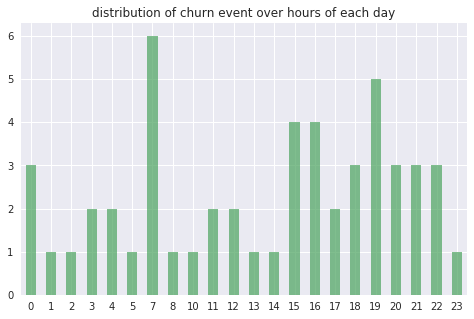

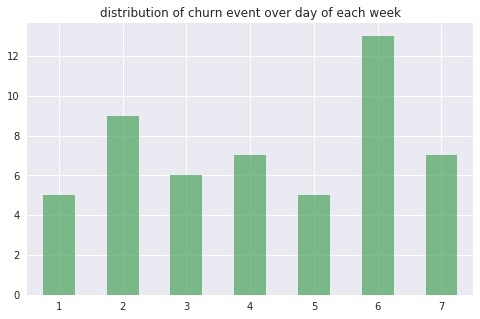

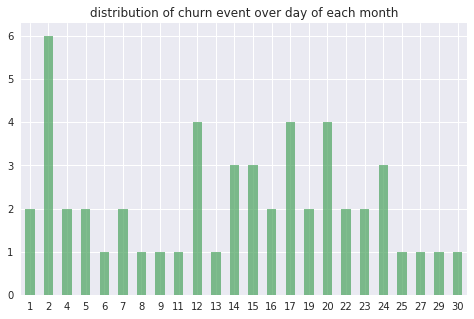

In [13]:
print("distribution of the Cancellation based on  weekDay, monthDay, hour of the day")
dfp = df_labelled.filter("page=='Cancellation Confirmation'").select(["weekDay", "monthDay", "hour"]).toPandas()
fig = plt.figure()
ax = plt.gca()
ax.set_title("distribution of churn event over hours of each day")
dfp["hour"].value_counts().sort_index().plot.bar(figsize=(8,5),color="g",ax=ax,alpha=0.75, rot=0);
fig = plt.figure()
ax = plt.gca()
ax.set_title("distribution of churn event over day of each week")
dfp["weekDay"].value_counts().sort_index().plot.bar(figsize=(8,5),color="g",ax=ax,alpha=0.75, rot=0);
fig = plt.figure()
ax = plt.gca()
ax.set_title("distribution of churn event over day of each month")
dfp["monthDay"].value_counts().sort_index().plot.bar(figsize=(8,5),color="g",ax=ax,alpha=0.75, rot=0);


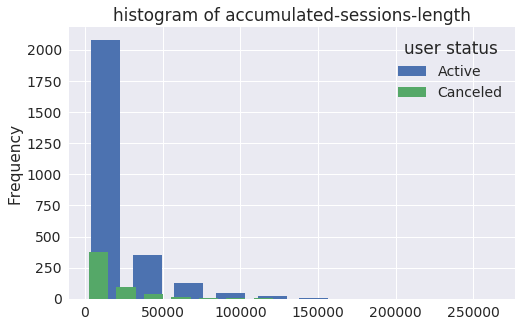

In [65]:
fig = plt.figure(figsize=(8,5))
ax = plt.gca()
ax.set_title("accumulated-sessions-length")
h, l = ax.get_legend_handles_labels()
ax.legend(h, ["Active", "Canceled"], title="user status")
df_labelled.filter("churn == 0").select(["userId","length","sessionId"]).groupBy("userId","sessionId").agg(F.sum("length").alias("Active")).toPandas()["Active"].plot(kind="hist", legend="Active", ax=ax,rwidth = 0.7);
df_labelled.filter("churn == 1").select(["userId","length","sessionId"]).groupBy("userId","sessionId").agg(F.sum("length").alias("Canceled")).toPandas()["Canceled"].plot(kind="hist",color="g", legend="Canceled", ax=ax,  rwidth = 0.7, );

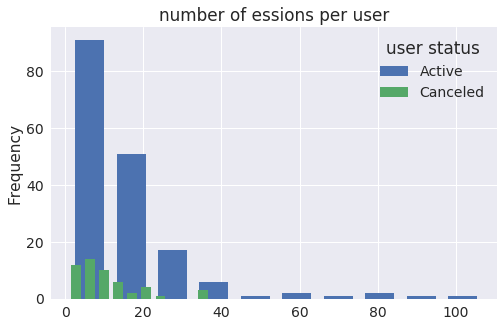

In [66]:
fig = plt.figure(figsize=(8,5))
ax = plt.gca()
ax.set_title("number of essions per user")
h, l = ax.get_legend_handles_labels()
ax.legend(h, ["Active", "Canceled"], title="user status")
df_labelled.filter("churn ==0").select(["userId","sessionId"]).drop_duplicates().groupBy("userId",).count().withColumn("Active", F.col("count")).toPandas()["Active"].plot(kind="hist", legend="Active", color="b", rwidth = 0.7, );
df_labelled.filter("churn ==1").select(["userId","sessionId"]).drop_duplicates().groupBy("userId",).count().withColumn("Canceled", F.col("count")).toPandas()["Canceled"].plot(kind="hist", legend="Canceled", color="g", rwidth = 0.7);

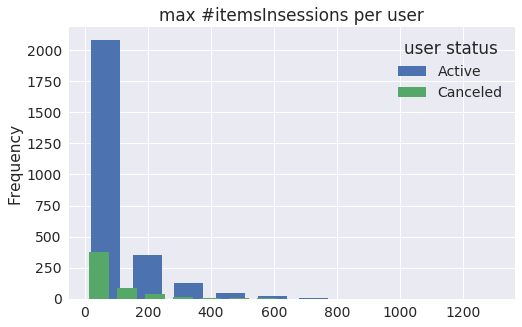

In [68]:
fig = plt.figure(figsize=(8,5))
ax = plt.gca()
ax.set_title("max #itemsInsessions per user")
h, l = ax.get_legend_handles_labels()
ax.legend(h, ["Active", "Canceled"], title="user status")
df_labelled.filter("churn ==0").groupBy(["userId","sessionId"]).agg(F.max("itemInSession").alias("Active")).toPandas()["Active"].plot(kind="hist",color="b",legend="Active", rwidth = 0.7,);
df_labelled.filter("churn ==1").groupBy(["userId","sessionId"]).agg(F.max("itemInSession").alias("Canceled")).toPandas()["Canceled"].plot(kind="hist",color="g", legend="Canceled", rwidth = 0.7,);


 plot churn frequency for categorical features


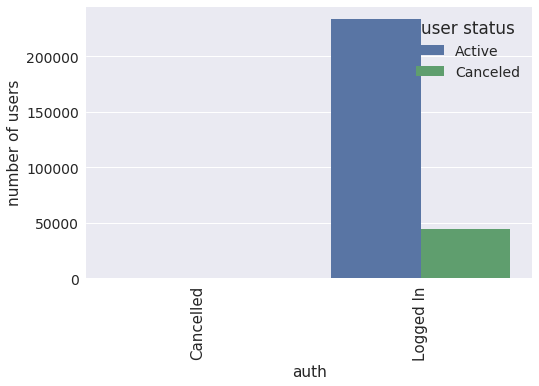

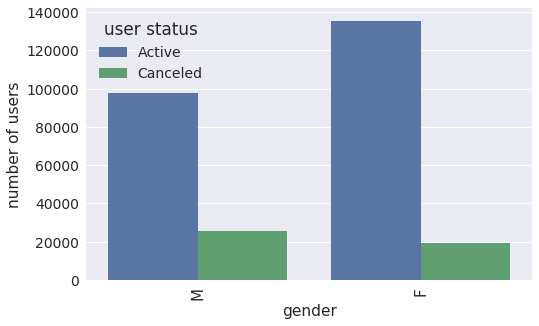

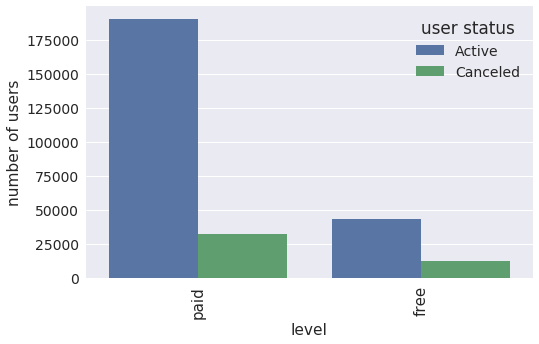

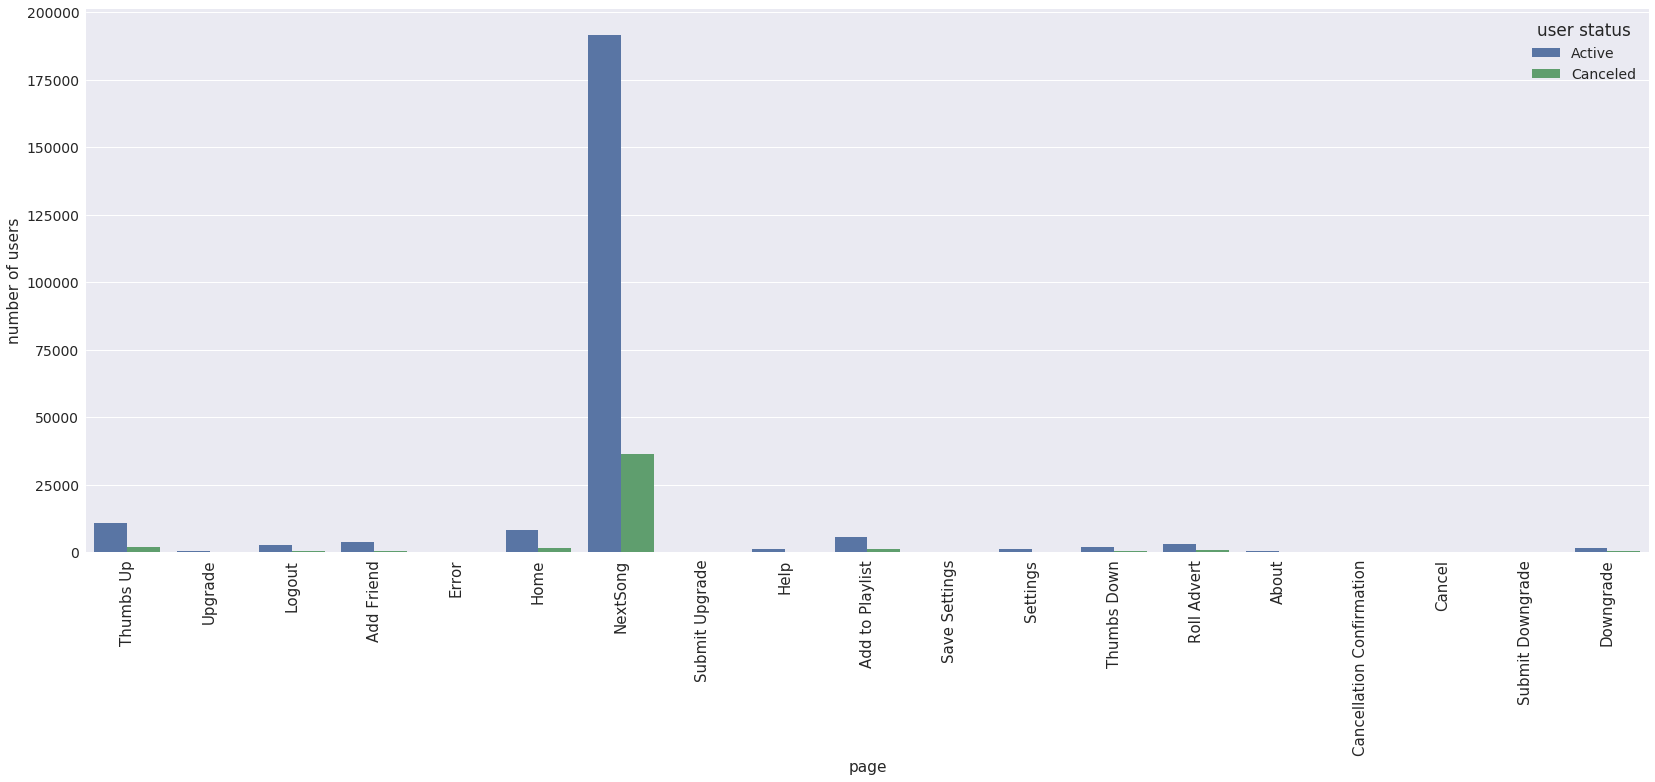

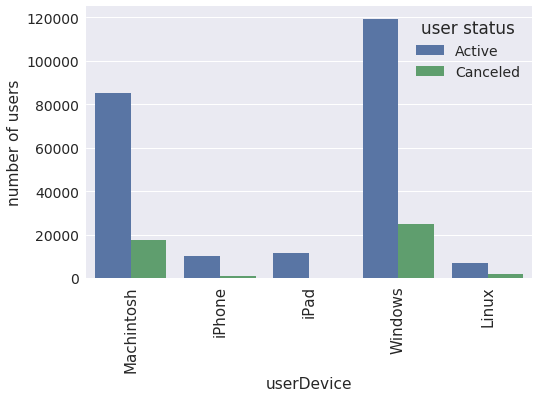

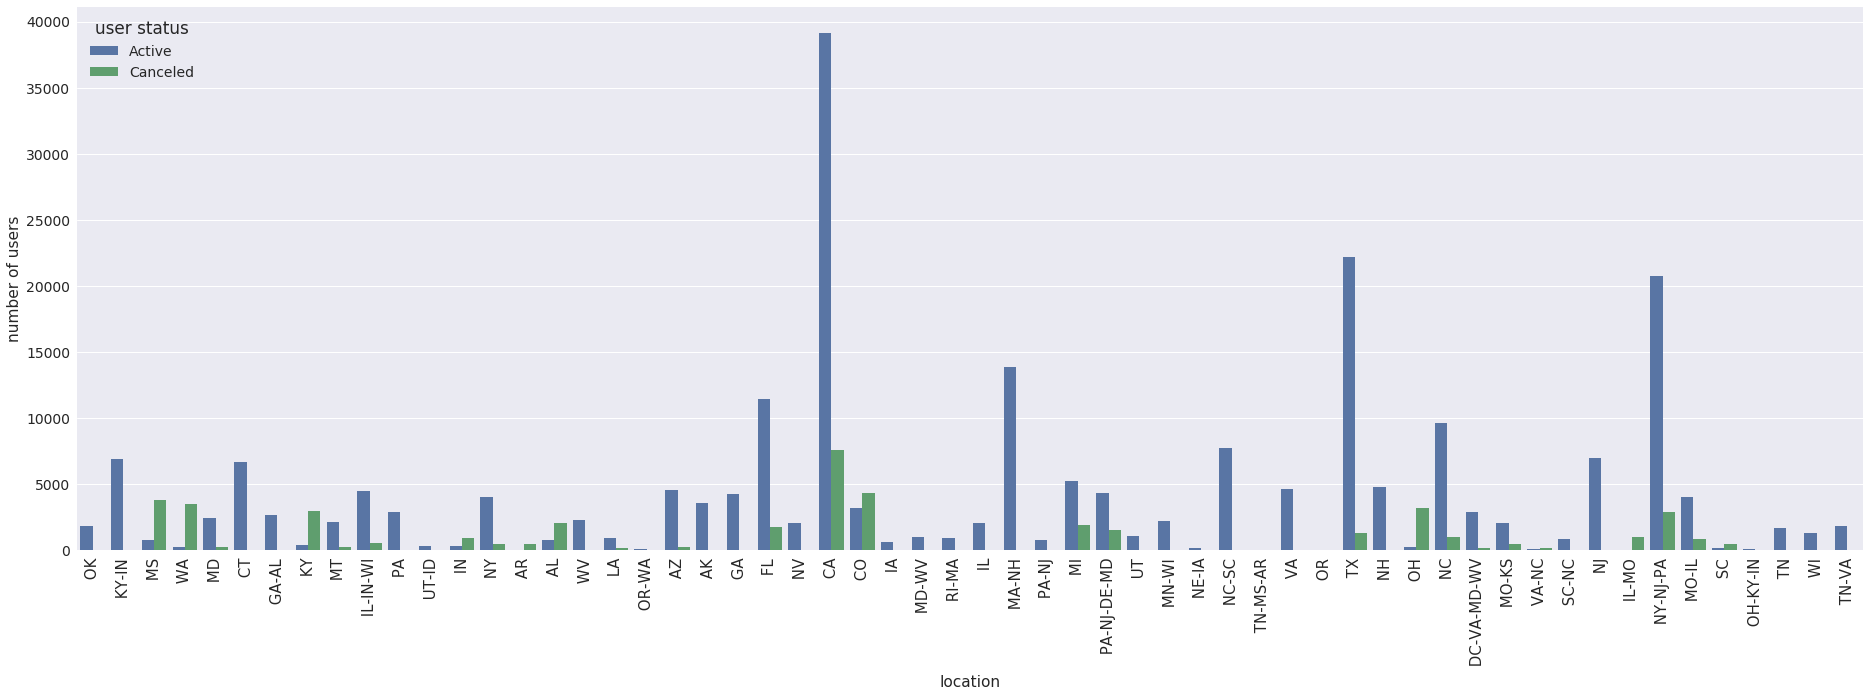

In [36]:
print("\n plot churn frequency for categorical features")
plot_churn_frequency(df_labelled, {"auth":(8,5), "gender":(8,5), "level":(8,5), "page":(28,10), "userDevice":(8,5), "location":(32,10)})

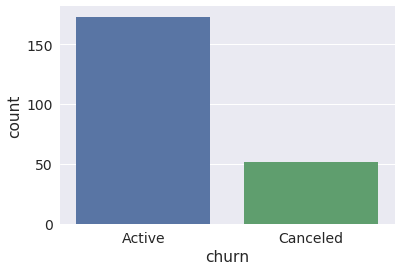

In [37]:
dfp = df_labelled.dropDuplicates(["userId"]).groupby(["churn"]).count().toPandas().set_index("churn")
ax = sns.barplot(x=dfp.index,y="count",data=dfp);
ax.set_xticklabels(["Active","Canceled"]);


 plot churn frequency for time features


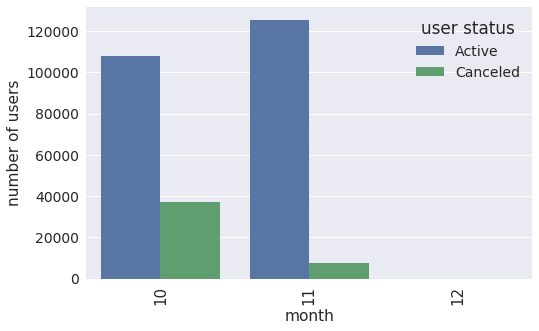

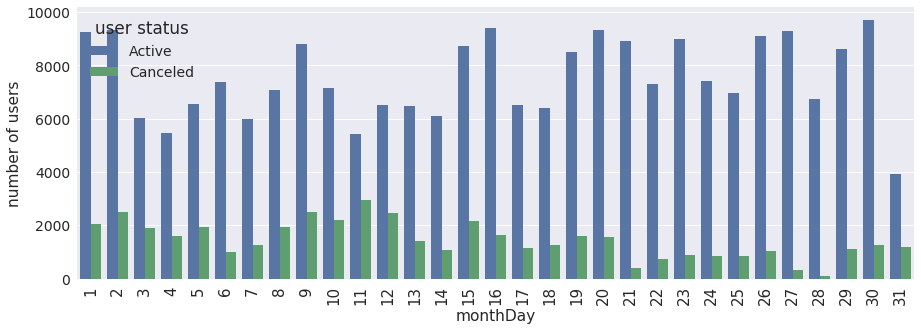

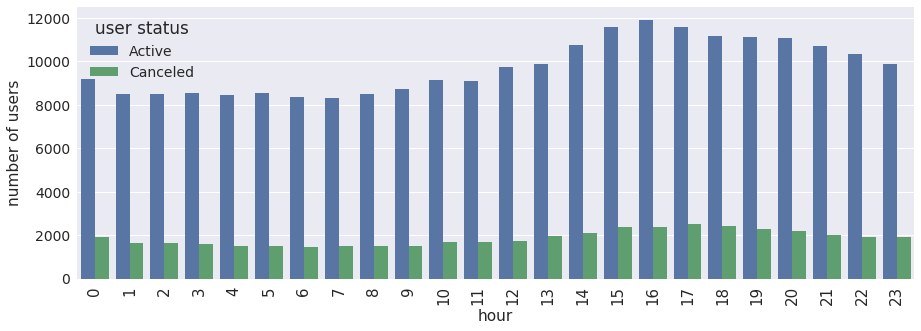

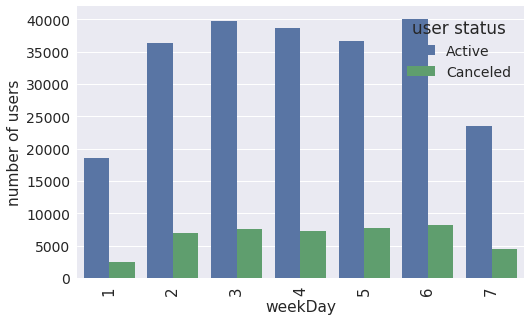

In [38]:
print("\n plot churn frequency for time features")
plot_churn_frequency(df_labelled, {"month":(8,5), "monthDay":(15,5), "hour":(15,5), "weekDay":(8,5)})

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

## <span style="color:blue"> Feature Generation Overview </span>
* the aim is to generated features from quantitative and qualitative raw data
* series of features generated based on the session activities such as:
    * number of sessions per month and per day
    * average duration of the session 
    * average song length
* series of features are generated based on the average visit to each pages activities in each month
* the categorical features such as [gender, autho,userDevice] converted to dummy features
* based on data distribution in the visualization above features related to [hour, monthday, weekday] would not contribute to classification results
* redundant columns from original raw data are being removed
* the histogram plot of all the features below shows that most of the features

### <span style="color:blue"> List of generated features</span>
 * AboutPageMonth: long (nullable = true)
 * AddFriendPageMonth: long (nullable = true)
 * AddtoPlaylistPageMonth: long (nullable = true)
 * DowngradePageMonth: long (nullable = true)
 * ErrorPageMonth: long (nullable = true)
 * HelpPageMonth: long (nullable = true)
 * HomePageMonth: long (nullable = true)
 * LogoutPageMonth: long (nullable = true)
 * NextSongPageMonth: long (nullable = true)
 * RollAdvertPageMonth: long (nullable = true)
 * SaveSettingsPageMonth: long (nullable = true)
 * SettingsPageMonth: long (nullable = true)
 * SubmitDowngradePageMonth: long (nullable = true)
 * SubmitUpgradePageMonth: long (nullable = true)
 * ThumbsDownPageMonth: long (nullable = true)
 * ThumbsUpPageMonth: long (nullable = true)
 * UpgradePageMonth: long (nullable = true)
 * activeDuration: double (nullable = true)
 * avgSessionDayDuration: double (nullable = true)
 * avgSessionMonthDuration: double (nullable = true)
 * avgSessionitemsDay: double (nullable = true)
 * avgSessionitemsMonth: double (nullable = true)
 * avgSessionsDay: double (nullable = true)
 * avgSessionsMonth: double (nullable = true)
 * churn: long (nullable = true)
 * genderF: long (nullable = true)
 * genderM: long (nullable = true)
 * itemInSession: long (nullable = true)
 * length: double (nullable = true)
 * levelfree: long (nullable = true)
 * levelpaid: long (nullable = true)
 * userDeviceLinux: long (nullable = true)
 * userDeviceMachintosh: long (nullable = true)
 * userDeviceWindows: long (nullable = true)
 * userDeviceiPad: long (nullable = true)
 * userDeviceiPhone: long (nullable = true)
 * userId: long (nullable = true)

In [9]:
def generate_page_based_features(df):
    """
    the following features are generated base userId and page activities 
        * rollAdvertPageMonth: double (nullable = false)
        * settingsPageMonth: double (nullable = false)
        * downgradePageMonth: double (nullable = false)
        * nextSongPageMonth: double (nullable = false)
        * errorPageMonth: double (nullable = false)
        * aboutPageMonth: double (nullable = false)
        * upgradePageMonth: double (nullable = false)
        * homePageMonth: double (nullable = false)
        * logoutPageMonth: double (nullable = false)
        * addtoPlaylistPageMonth: double (nullable = false)
        * thumbsDownPageMonth: double (nullable = false)
        * thumbsUpPageMonth: double (nullable = false)
        * saveSettingsPageMonth: double (nullable = false)
        * addFriendPageMonth: double (nullable = false)
        * submitUpgradePageMonth: double (nullable = false)
        * helpPageMonth: double (nullable = false)
        * submitDowngradePageMonth: double (nullable = false)
       
    :param df: Spark DataFrame
    :return df: Spark DataFrame
    """
    print("\n add features based on page activities")
    tmdf = df.select(["userId", "month", "page"]).filter(~F.col("page").isin(["Cancel","Cancellation Confirmation"])).groupBy("userId", "month",).pivot("page").count().fillna(0)
    for c in tmdf.columns:
        if c not in ["userId", "month", "page"]: 
            tmdf = tmdf.withColumnRenamed(c, "".join([c.replace(" ",""),"PageMonth"]))
    tmdf = tmdf.drop("month","page")
    df = tmdf.join(df, on="userId")
    return df

In [48]:
df = generate_page_based_features(df_labelled)



 add features based on page activities


In [49]:
def generate_dummy(df, dum_col):
    """
    get dummy variables for given column
    :param df: Spark DataFrame
    :return df: Spark DataFrame
    """
    print("\n add dummy features based {}".format(dum_col))
    tmdf = df.groupBy("userId").pivot(dum_col).count().fillna(0)
    for c in tmdf.columns:
        if c not in ["userId", dum_col]: 
            tmdf = tmdf.withColumnRenamed(c, "".join([dum_col,c.replace(" ","")]))
    df = tmdf.join(df, on="userId")
    df = df.drop(dum_col)
    return df

def generate_dummies_based_features(df):
    """
    generate dummy features for each user from following columns 
        * auth: string (nullable = true)
        * gender: string (nullable = true)
        * level: string (nullable = true)        
        * userDevice: string (nullable = true)
       
    :param df: Spark DataFrame
    :return df: Spark DataFrame
    """
    
    df = generate_dummy(df, "gender")
    df = generate_dummy(df, "level")
    df = generate_dummy(df, "userDevice")
   
    return df 
     

In [50]:
df = generate_dummies_based_features(df)



 add dummy features based gender

 add dummy features based level

 add dummy features based userDevice


In [51]:
def generate_session_based_features(df):
    """
    the following features are generated base userId and sessionId 
        * avgSessionsMonth: double (nullable = true)
        * avgSessionMonthDuration: double (nullable = true)
        * avgSessionitemsMonth: double (nullable = true)
        * avgSessionsDay: double (nullable = true)
        * avgSessionDayDuration: double (nullable = true)
        * avgSessionitemsDay: double (nullable = true)
        * activeDuration: double(nullable = true)
        * avgLength: double(nullable = true)
    :param df: Spark DataFrame
    :return df: Spark DataFrame
    """
    
    # monthly features
    print("\n add average number of session in each month per user 'avgSessionsMonth'")
    tmdf1 = df.groupby("userId","month").agg(F.countDistinct("sessionId").alias("avgSessionsMonth")).groupBy("userId").avg("avgSessionsMonth").withColumnRenamed("avg(avgSessionsMonth)", "avgSessionsMonth")
    
    print("\n add average session duration in each month per user 'avgSessionMonthDuration' ")
    tmdf2 = df.groupby("userId","month","sessionId").agg(F.max("ts").alias("session_end"), F.min("ts").alias("session_start")).withColumn("avgSessionMonthDuration", (F.col("session_end")- F.col("session_start"))*0.001).\
           groupby("userId","month").avg("avgSessionMonthDuration").groupby("userId").agg(F.mean("avg(avgSessionMonthDuration)").alias("avgSessionMonthDuration"))
    
    print("\n add average number of session items in each month per user 'avgSessionitemsMonth'")
    tmdf3 = df.groupby("userId","sessionId", "month").agg(F.max("itemInSession").alias("avgSessionitemsMonth")).groupBy("userId").avg("avgSessionitemsMonth").withColumnRenamed("avg(avgSessionitemsMonth)", "avgSessionitemsMonth")
    
    # daily features
    print("\n add average number of session in each day per user 'avgSessionsDay'")
    tmdf4 = df.groupby("userId", "date").agg(F.countDistinct("sessionId").alias("avgSessionsDay")).groupBy("userId").avg("avgSessionsDay").withColumnRenamed("avg(avgSessionsDay)", "avgSessionsDay")
    
    print("\n add average number of session duration in each day 'avgSessionDayDuration'")
    tmdf5 = df.groupby("userId","date","sessionId").agg(F.max("ts").alias("session_end"), F.min("ts").alias("session_start")).withColumn("avgSessionDayDuration", (F.col("session_end")- F.col("session_start"))*0.001).\
            groupby("userId","date").avg("avgSessionDayDuration").groupby("userId").agg(F.mean("avg(avgSessionDayDuration)").alias("avgSessionDayDuration"))
        
    print("\n add average session items in each day per user 'avgSessionitemsDay'")
    tmdf6 = df.groupby("userId", "sessionId", "date").agg(F.max("itemInSession").alias("avgSessionitemsDay")).groupBy("userId").avg("avgSessionitemsDay").withColumnRenamed("avg(avgSessionitemsDay)", "avgSessionitemsDay")
    
    print("\n add user's active time duration since registration 'activeDuration'")
    tmdf7 = df.groupBy("userId").agg((F.max(F.col("ts"))-F.min(F.col("registration")))*0.001).withColumnRenamed("((max(ts) - min(registration)) * 0.001)","activeDuration")
    
    print("\n add average length song which a users have listened ")
    tmdf8 = df.groupBy("userId").agg(F.avg("length").alias("avgLength"))
    
    return tmdf1.join(tmdf2, on="userId").join(tmdf3, on="userId").join(tmdf4, on="userId").join(tmdf5, on="userId").join(tmdf6, on="userId").join(tmdf7, on="userId").join(tmdf8, on="userId").join(df, on="userId")

In [52]:
df = generate_session_based_features(df)



 add average number of session in each month per user 'avgSessionsMonth'

 add average session duration in each month per user 'avgSessionMonthDuration' 

 add average number of session items in each month per user 'avgSessionitemsMonth'

 add average number of session in each day per user 'avgSessionsDay'

 add average number of session duration in each day 'avgSessionDayDuration'

 add average session items in each day per user 'avgSessionitemsDay'

 add user's active time duration since registration 'activeDuration'

 add average length song which a users have listened 


In [53]:
df = df.drop("artist", "length", "firstName", "lastName","sessionId", "location", "method", "userAgent", "page","song","auth","registration", "ts","date", "day", "month", "hour", "monthDay", "status", "weekDay")
df = df.dropDuplicates()
df.printSchema()


root
 |-- userId: long (nullable = true)
 |-- avgSessionsMonth: double (nullable = true)
 |-- avgSessionMonthDuration: double (nullable = true)
 |-- avgSessionitemsMonth: double (nullable = true)
 |-- avgSessionsDay: double (nullable = true)
 |-- avgSessionDayDuration: double (nullable = true)
 |-- avgSessionitemsDay: double (nullable = true)
 |-- activeDuration: double (nullable = true)
 |-- avgLength: double (nullable = true)
 |-- userDeviceLinux: long (nullable = true)
 |-- userDeviceMachintosh: long (nullable = true)
 |-- userDeviceWindows: long (nullable = true)
 |-- userDeviceiPad: long (nullable = true)
 |-- userDeviceiPhone: long (nullable = true)
 |-- levelfree: long (nullable = true)
 |-- levelpaid: long (nullable = true)
 |-- genderF: long (nullable = true)
 |-- genderM: long (nullable = true)
 |-- AboutPageMonth: long (nullable = true)
 |-- AddFriendPageMonth: long (nullable = true)
 |-- AddtoPlaylistPageMonth: long (nullable = true)
 |-- DowngradePageMonth: long (nullable 

In [54]:
dfp = df.toPandas()

/opt/conda/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


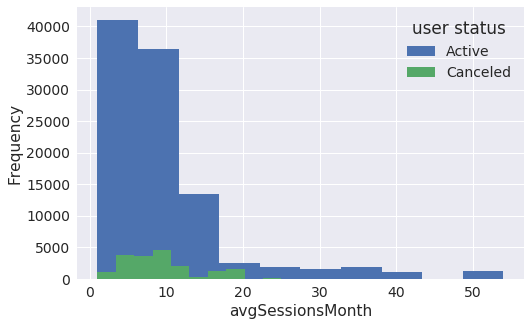

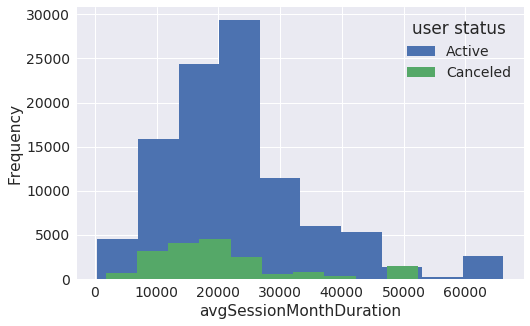

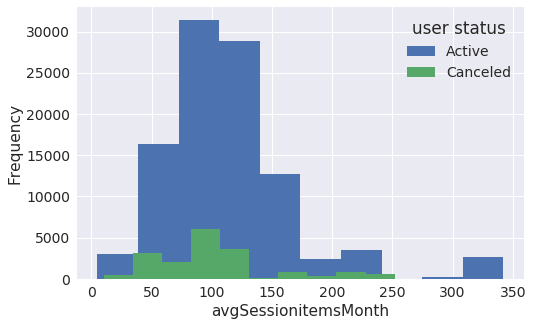

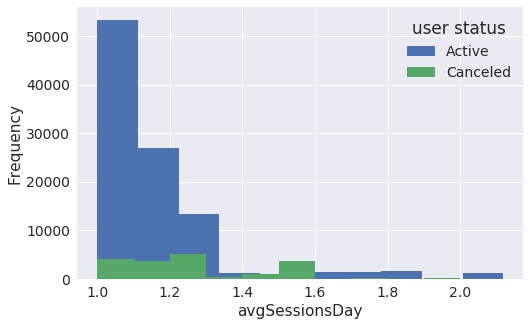

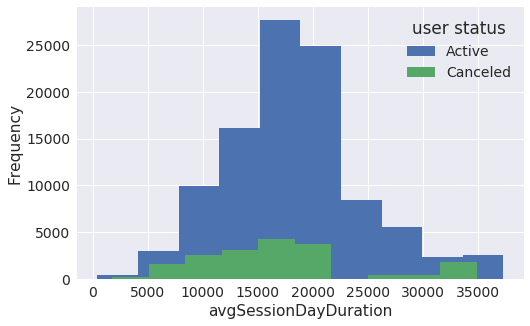

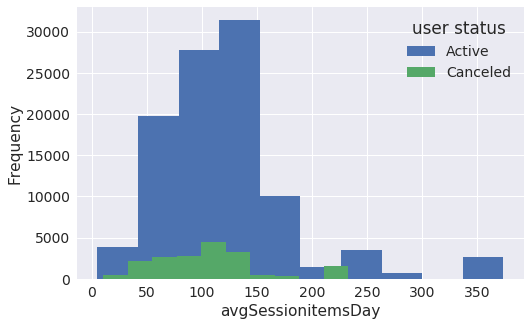

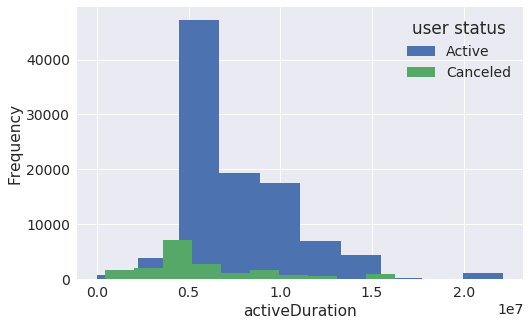

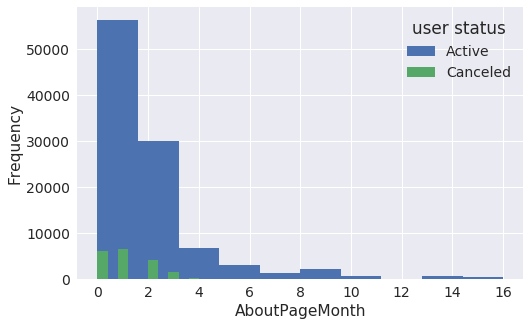

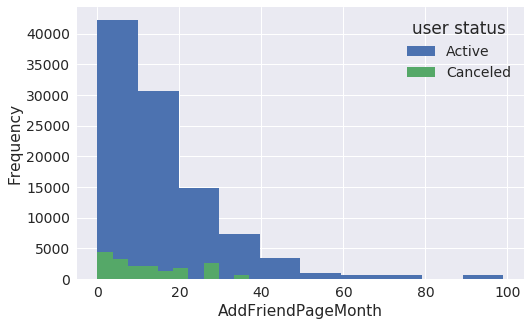

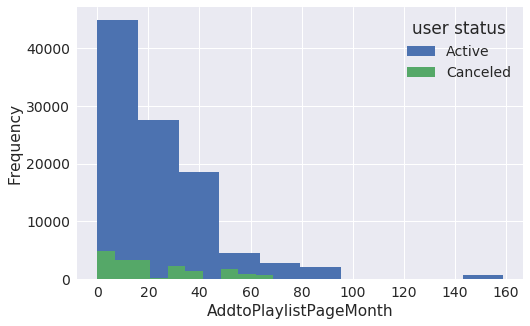

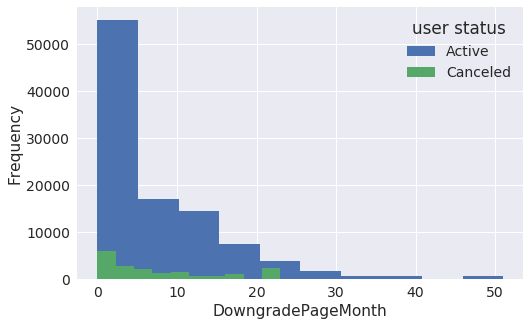

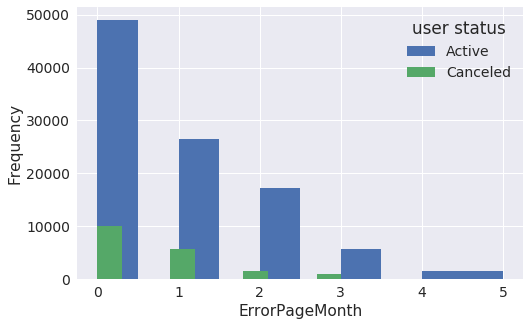

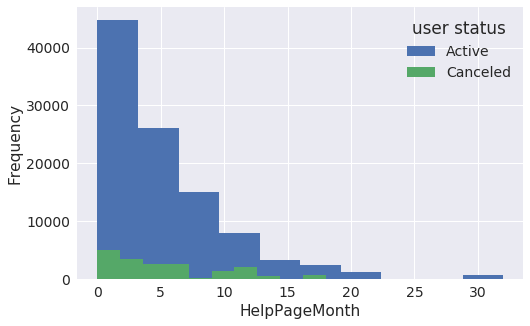

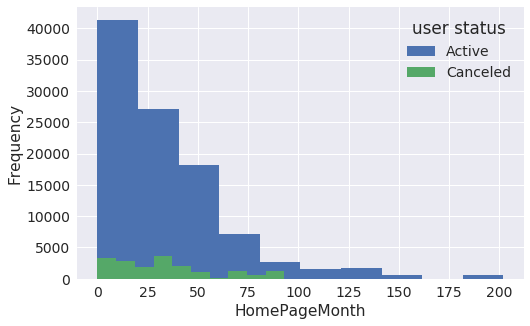

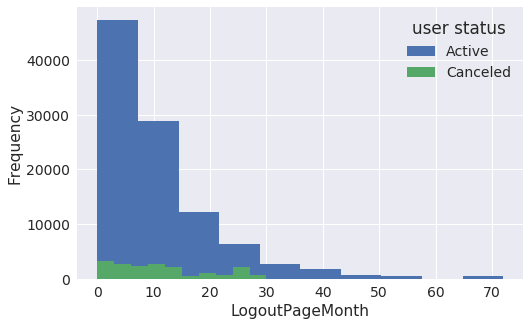

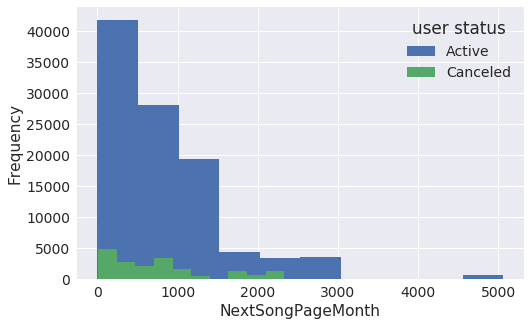

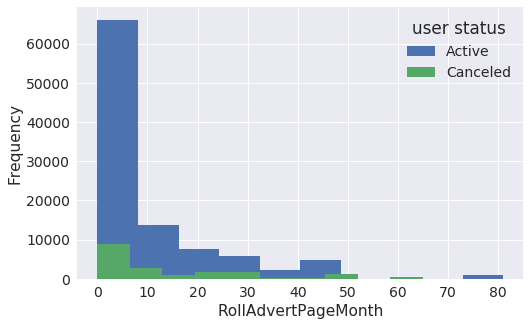

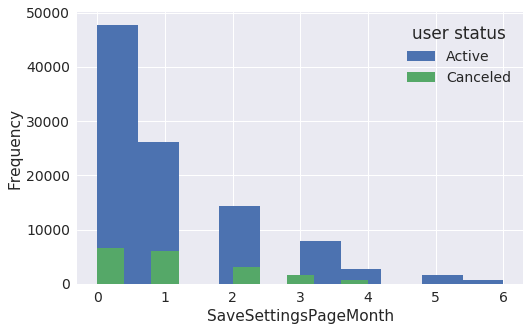

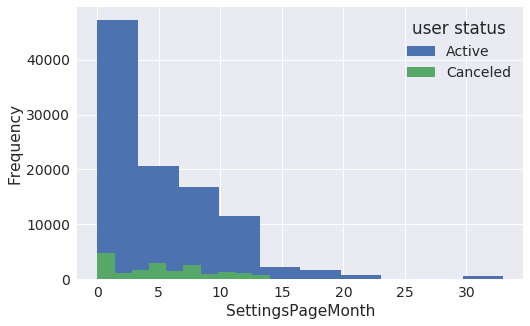

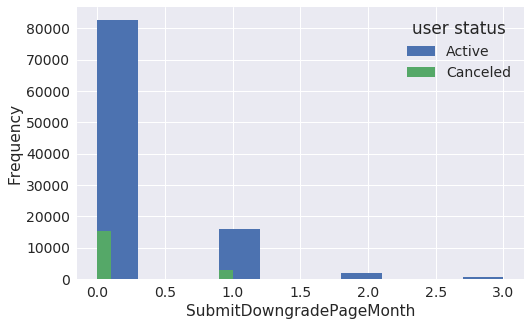

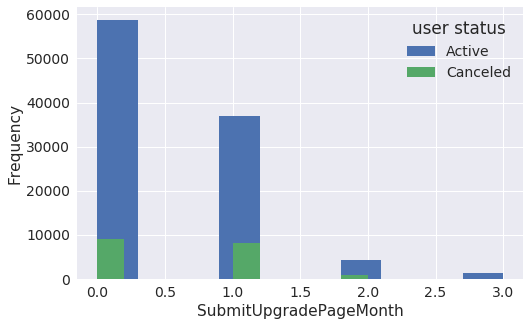

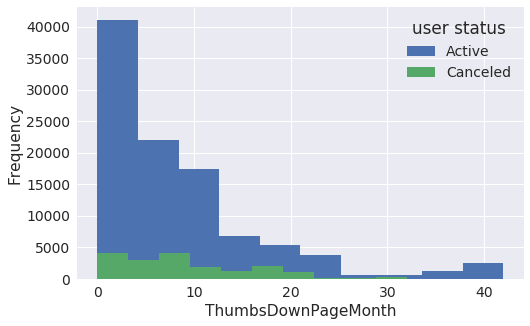

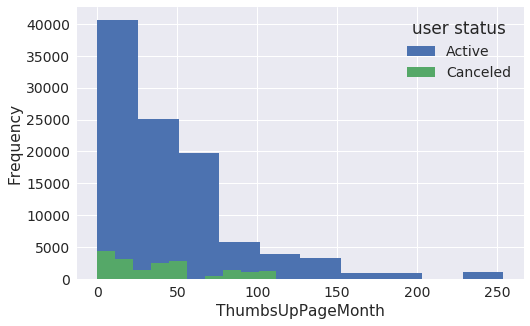

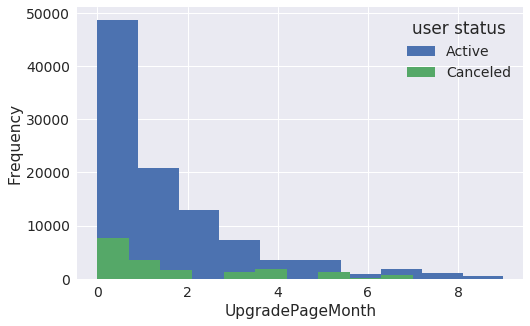

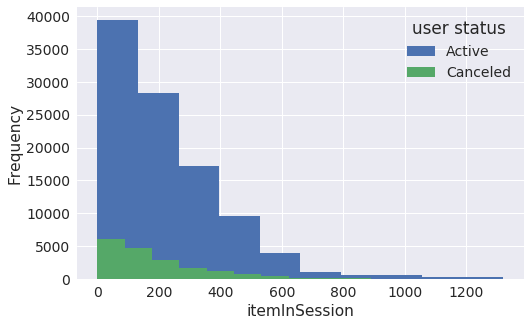

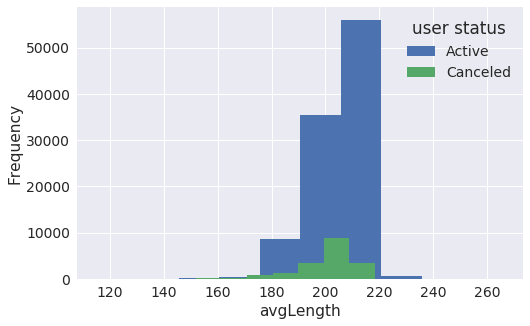

In [55]:
column_list = ["avgSessionsMonth", "avgSessionMonthDuration", "avgSessionitemsMonth", "avgSessionsDay", "avgSessionDayDuration", "avgSessionitemsDay", "activeDuration", 
                          "AboutPageMonth", "AddFriendPageMonth", "AddtoPlaylistPageMonth", "DowngradePageMonth", "ErrorPageMonth", "HelpPageMonth", "HomePageMonth", "LogoutPageMonth", 
                          "NextSongPageMonth", "RollAdvertPageMonth", "SaveSettingsPageMonth", "SettingsPageMonth", "SubmitDowngradePageMonth","SubmitUpgradePageMonth", "ThumbsDownPageMonth", 
                          "ThumbsUpPageMonth", "UpgradePageMonth", "itemInSession", "avgLength"]
for c in column_list:
    fig = plt.figure(figsize=(8,5))
    ax = fig.gca()
    h = dfp[dfp.churn==0.0][c].plot.hist(color='b', ax=ax,)
    h = dfp[dfp.churn==1.0][c].plot.hist(color='g', ax=ax)
    h, l = ax.get_legend_handles_labels()
    ax.set_xlabel(c)
    ax.legend(h, ["Active", "Canceled"], title="user status")

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2961: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  exec(code_obj, self.user_global_ns, self.user_ns)


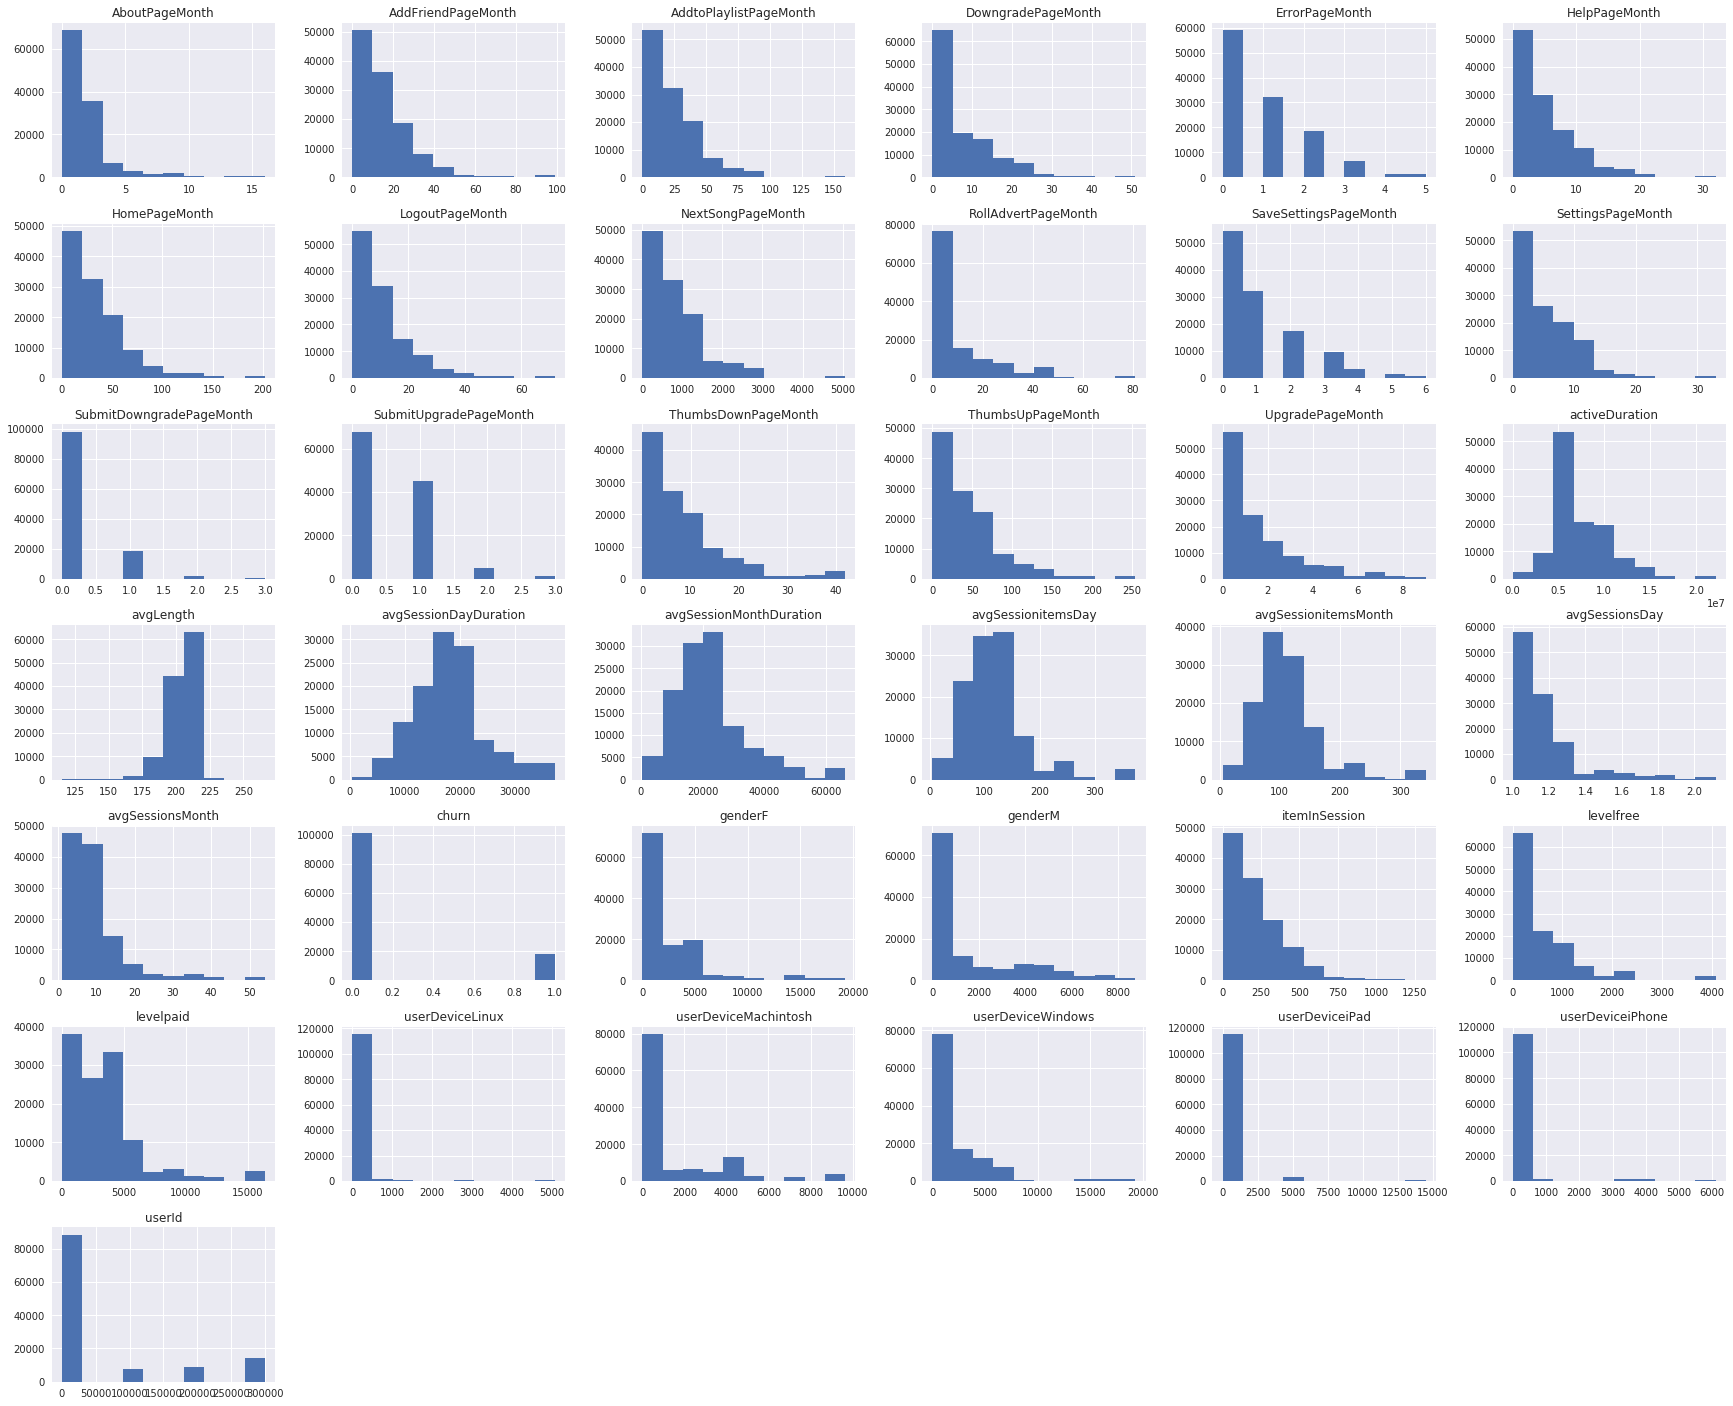

In [38]:
fig = plt.figure(figsize=(30,25))
ax = fig.gca()
h = dfp.hist(ax=ax)

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

## <span style="color:blue"> Feature Scaling and Modeling Overview </span>
* **Setup**:
 
 * The MinMaxScaler is used as a preprocessing step for improving the performance of classification
 * The Correlation plot shows a strong correlation between some page-visiting-frequency features and paid and free users
 * there are in total 36 features are used as clarifiers input
 * the curse of dimensionality would not affect the performance here due to the low ratio of feature numbers to sample numbers
 * the if order deduce the churn users we used three different classification algorithms ["LogisticRegression","GBTClassifier", "RandomForestClassifier"]
 * the PCA algorithms is used to extract a subset of features to boost the performance of the classifiers
* **Results Explanation**:
 * the Gradient tree boosting outperformers LogisticRegression and RadomForest
 * the advantage GBT is it can deal with skewed features much better than the other two algorithms
 * The GTB algorithm also deals with the imbalanced number class samples much robustly 
 * the confusion matric shows that GTB has the least number of false negatives
 * the use of PCA decreases the performance of all classifiers, it might be essential to use all features
 
* **Potential Feature Work**:
 * most of the feature in this work is an intrinsically temporal feature, calculated over a time window.
 * Therefore the classification algorithms rely on the accumulation of the data through time and generating features. 
 * Alternatively, we could train models using recurrent neural networks(RNN) to contain these type temporal features as a latent variable in their neuron state.
 * Via RNN models, we can predict the action of the users and learn the chain of the activities which lead to churn event.
 * Such algorithms require training of full dataset and other third-party libraries such as PyTorch in combination with PySpark.
 * Furthermore, we can scale up our workflow by using big data distributed on the cluster and get the full benefit of the data-driven solutions.

In [6]:
def feature_scaling(df):  
    """
    apply MinMax scaling on the desired features
    :param df:
    :return:
    """
    feature_cols = df.drop("userId", "churn").columns
    df = df.withColumn("label", df["churn"].cast(pysTypes.DoubleType()))
    assembler = VectorAssembler(inputCols=feature_cols, outputCol="feature_vec")
    
    #pyspark default name for features vector column: 'featuresCol'
    minmaxscaler = MinMaxScaler(inputCol="feature_vec", outputCol="features")
    
    df = assembler.transform(df)
    minmaxscaler_model = minmaxscaler.fit(df)
    scaled_df = minmaxscaler_model.transform(df)
    return scaled_df

In [7]:
def custom_evaluation(clf_pred_results, model_name):
    """
    Perform custom evaluation of predictions
       - inspect with PySpark.ML evaluator (will use for pipeline)
       - use RDD-API; PySpark.MLLib to get metrics based on predictions 
       - display confusion matrix
    :param clf_pred_results: Spark Dataframe
    :param model_name: String name of classifier
    """
    
    pr = BinaryClassificationEvaluator(metricName="areaUnderPR")
    
    pr_auc=pr.evaluate(clf_pred_results)
    print("\n BinaryClassificationEvaluator results:")
    print(f"{model_name} -> PR AUC: {pr_auc}")
    
    predictionRDD = clf_pred_results.select(["label", "prediction"]).rdd\
                        .map(lambda line: (line[1], line[0]))
    metrics = MulticlassMetrics(predictionRDD)
    print("\n MulticlassMetrics results:")
    print(f"{model_name}\n | precision = {metrics.precision()}")
    print(f" | recall = {metrics.recall()}\n | F1-Score = {metrics.fMeasure()}")
    
    conf_matrix = metrics.confusionMatrix().toArray()
    sns.set(font_scale=1.4)#for label size
    ax = sns.heatmap(conf_matrix, annot=True,annot_kws={"size": 16})
    ax.set(xlabel="Predicted Label", ylabel="True Label", title="Confusion Mtx")
    plt.show()

In [8]:
def train_predict_models(train_df, test_df, model_name, featuresCol='features', labelCol='label',):
    """
    build the classification model and train the and test on the given dataframe and visualize the results
    :params train_df: Spark Dataframe
    :params test_df: Spark Dataframe
    :param model_name: classification model name
    :param featureCol: String name of the feature column used via classifier
    :param labelCol: String name of the label column used vi classifier
    """
    
    if model_name == "LogisticRegression":
        ml_model = LogisticRegression(featuresCol=featuresCol, labelCol=labelCol)
    elif model_name == "RandomForestClassifier":
        ml_model = RandomForestClassifier(featuresCol=featuresCol, labelCol=labelCol)
    elif model_name == "GBTClassifier":
        ml_model = GBTClassifier(featuresCol=featuresCol, labelCol=labelCol)
    else:
        print("\n expected classifiers are: [GBTClassifier, RandomForestClassifier, LogisticRegression]")

    clf_model = ml_model.fit(train_df)
    results_clf = clf_model.transform(test_df)
    custom_evaluation(results_clf, model_name)

In [9]:
def plot_correlation(df, feature_column, plt_title="correlation of scaled features", set_tick_label=True):
    """
    plot correlation of scaled features 
    :param df: Spark Dataframe
    :param feature_column: String name of the feature column
    :param plt_title: String plot title
    :param set_tick_label: bool if True set labels for x and x ticks
    """
    pearsonCorr = Correlation.corr(df, feature_column, "pearson").collect()[0][0]
    fig = plt.figure(figsize=(25,25))
    ax = fig.gca()
    ax.set_title(plt_title)
    sns.set(font_scale=3)
    p = sns.heatmap(pearsonCorr.toArray(),ax=ax, robust=True,cmap="YlGnBu")
    if set_tick_label:
        df_cols = scaled_df.drop("userId","features","churn","label","feature_vec").columns
        p.set_yticklabels(df_cols, size=15,rotation=0)
        p.set_xticklabels(df_cols, size=15,rotation=90)

In [38]:
def find_best_pca_param(scaled_df, init_k=5, variance_percentage=0.95):
    """
    :param scaled_df: Spark DataFrame
    :param init_k: Integer initial value for PCA hyper parameters k
    :param variance_percentage: Double expected minimum feature variance explained via PCA features
    """
    pca = PCA(k=init_k, inputCol="features", outputCol="pcaFeatures")
    pca_model = pca.fit(scaled_df)
    for i in range(10):
        if pca_model.explainedVariance.sum() >= variance_percentage:
            print("\n the first {} features of PCA model represents {}% of the data".format(init_k + i,
                                                                                            variance_percentage))
            break
        pca = PCA(k=init_k + i, inputCol="features", outputCol="pcaFeatures")
        pca_model = pca.fit(scaled_df)
       
            
    pca_results = pca_model.transform(scaled_df).select("userId", "label", "pcaFeatures")
    return pca_results

In [20]:
df = df.toDF("userId", "avgSessionsMonth", "avgSessionMonthDuration", "avgSessionitemsMonth", "avgSessionsDay", "avgSessionDayDuration", "avgSessionitemsDay", "activeDuration",
         "userDeviceLinux", "userDeviceMachintosh", "userDeviceWindows", "userDeviceiPad", "userDeviceiPhone", "levelfree", "levelpaid",
         "genderF", "genderM", "AboutPageMonth", "AddFriendPageMonth", "AddtoPlaylistPageMonth", "DowngradePageMonth", "ErrorPageMonth", "HelpPageMonth",
         "HomePageMonth", "LogoutPageMonth", "NextSongPageMonth", "RollAdvertPageMonth", "SaveSettingsPageMonth", "SettingsPageMonth", "SubmitDowngradePageMonth",
         "SubmitUpgradePageMonth", "ThumbsDownPageMonth", "ThumbsUpPageMonth", "UpgradePageMonth", "itemInSession", "avgLength", "churn")
scaled_df = feature_scaling(df)


In [21]:
ratio = 0.8
train_scaled_df = scaled_df.sampleBy('label', fractions={0.0:ratio, 1.0:ratio}, seed=123)
test_scaled_df = scaled_df.subtract(train_scaled_df)

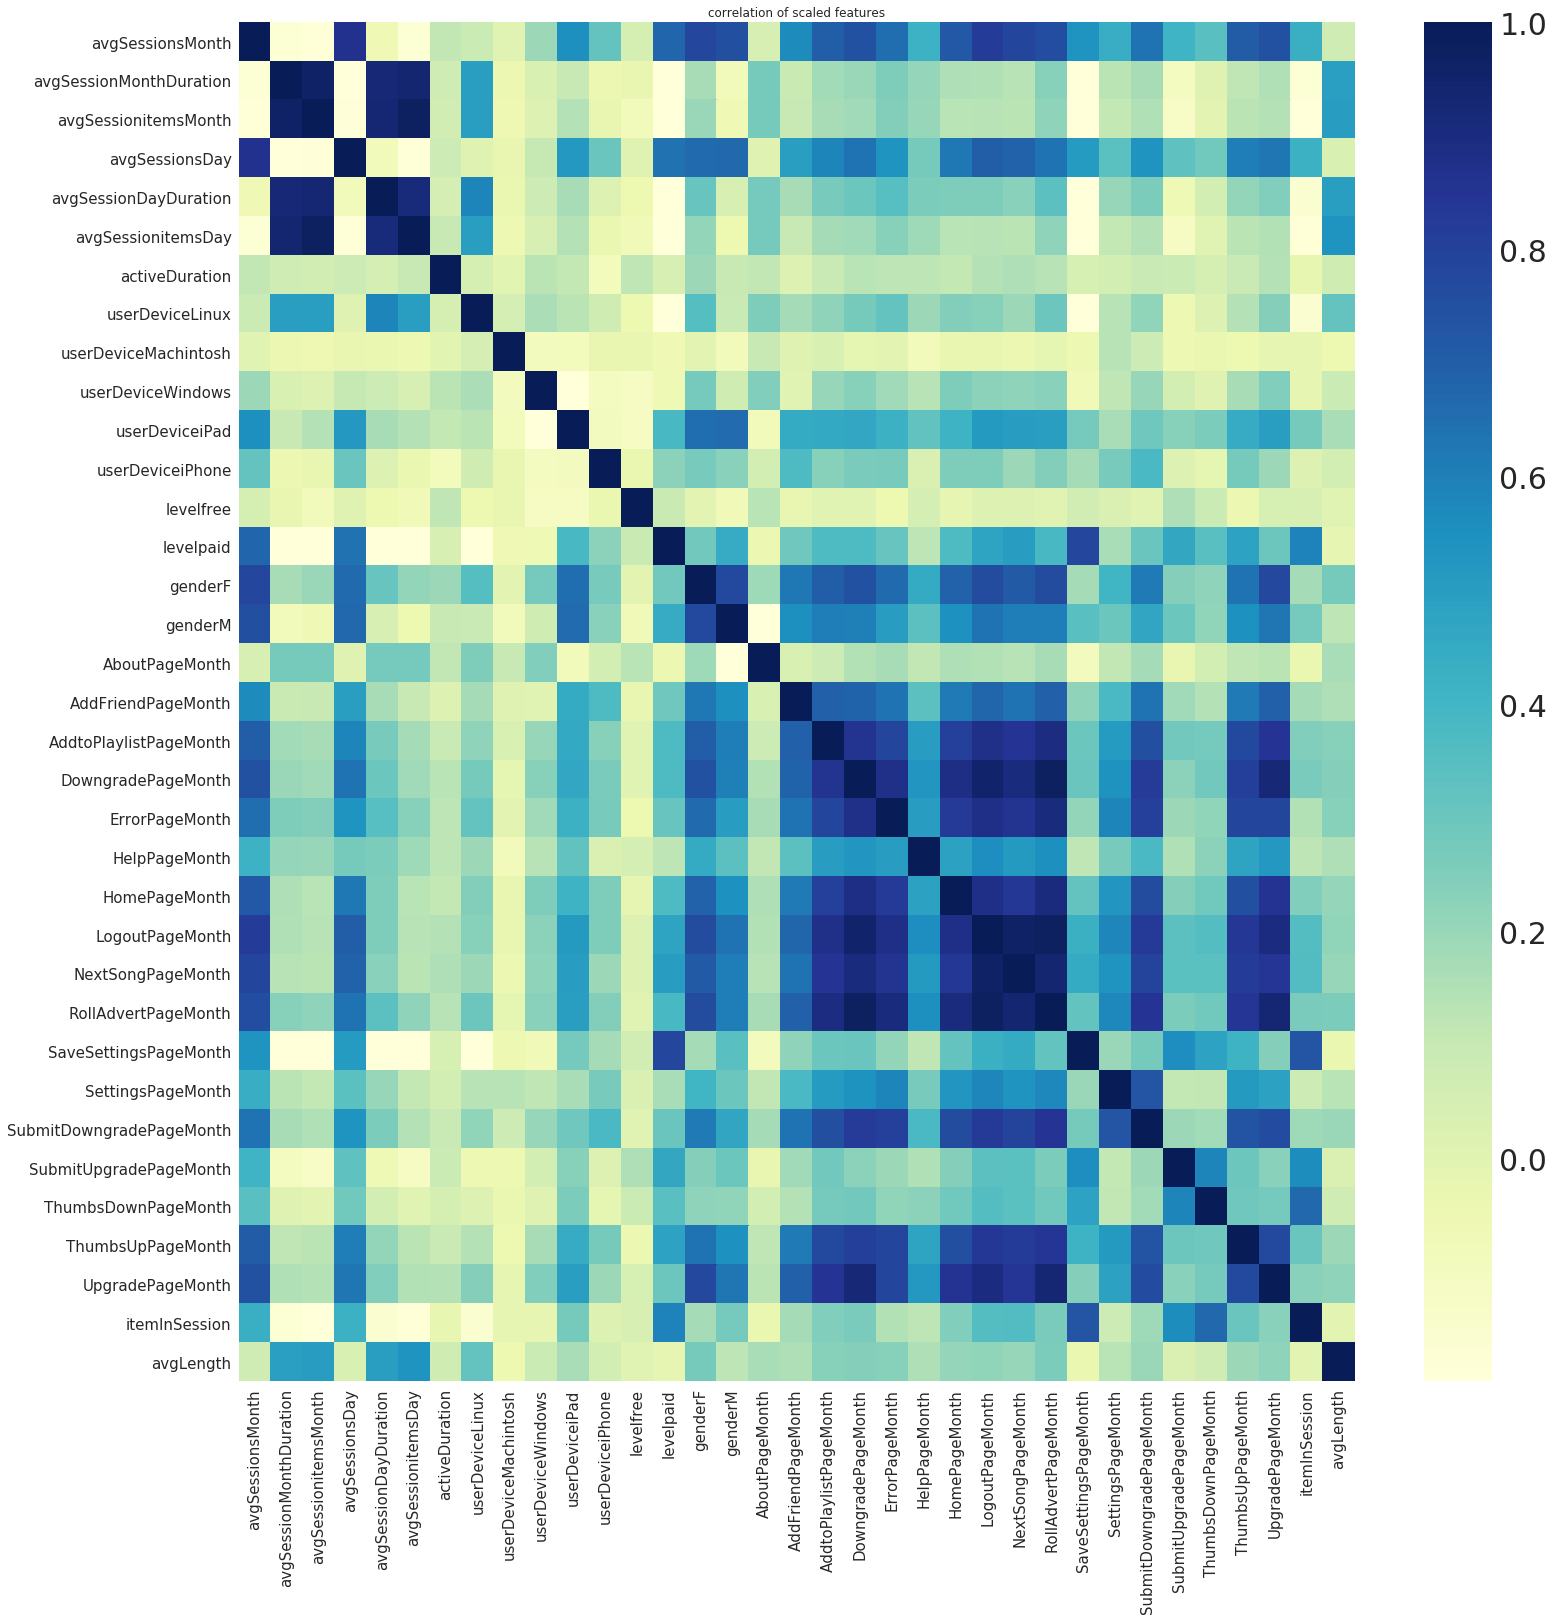

In [45]:
plot_correlation(scaled_df,"features")


 using scaled features train, test, and visualized results of: LogisticRegression

 BinaryClassificationEvaluator results:
LogisticRegression -> PR AUC: 0.7806860200781442

 MulticlassMetrics results:
LogisticRegression
 | precision = 0.9292462733571278
 | recall = 0.9292462733571278
 | F1-Score = 0.9292462733571278


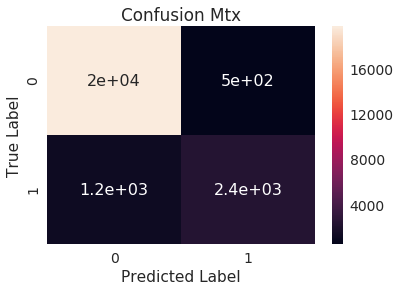


 using scaled features train, test, and visualized results of: GBTClassifier

 BinaryClassificationEvaluator results:
GBTClassifier -> PR AUC: 1.0

 MulticlassMetrics results:
GBTClassifier
 | precision = 0.9998740289733361
 | recall = 0.9998740289733361
 | F1-Score = 0.9998740289733361


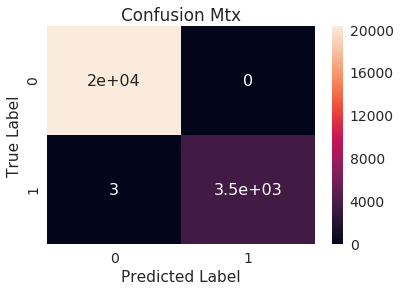


 using scaled features train, test, and visualized results of: RandomForestClassifier

 BinaryClassificationEvaluator results:
RandomForestClassifier -> PR AUC: 0.9833005251988683

 MulticlassMetrics results:
RandomForestClassifier
 | precision = 0.9603191266008818
 | recall = 0.9603191266008818
 | F1-Score = 0.9603191266008818


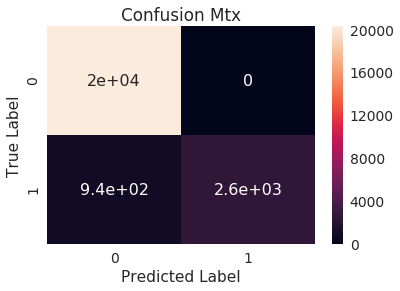

In [22]:
for clf_name in ["LogisticRegression","GBTClassifier", "RandomForestClassifier"]:
    print("\n using scaled features train, test, and visualized results of: {}".format(clf_name))
    train_predict_models(train_scaled_df, test_scaled_df, clf_name)

In [35]:
pca_result = find_best_pca_param(scaled_df, init_k=17, variance_percentage=0.95)


 the first 17 features of PCA model represents 0.95% of the data


In [36]:
ratio = 0.8
train_pca_df = pca_result.sampleBy('label', fractions={0.0:ratio, 1.0:ratio}, seed=123)
test_pca_df = pca_result.subtract(train_pca_df)


 using PCA features train, test, and visualized results of: LogisticRegression

 BinaryClassificationEvaluator results:
LogisticRegression -> PR AUC: 1.0

 MulticlassMetrics results:
LogisticRegression
 | precision = 1.0
 | recall = 1.0
 | F1-Score = 1.0


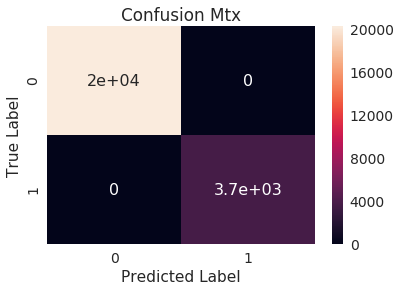


 using PCA features train, test, and visualized results of: GBTClassifier

 BinaryClassificationEvaluator results:
GBTClassifier -> PR AUC: 1.0

 MulticlassMetrics results:
GBTClassifier
 | precision = 1.0
 | recall = 1.0
 | F1-Score = 1.0


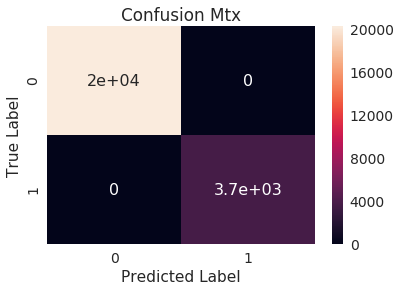


 using PCA features train, test, and visualized results of: RandomForestClassifier

 BinaryClassificationEvaluator results:
RandomForestClassifier -> PR AUC: 1.0

 MulticlassMetrics results:
RandomForestClassifier
 | precision = 1.0
 | recall = 1.0
 | F1-Score = 1.0


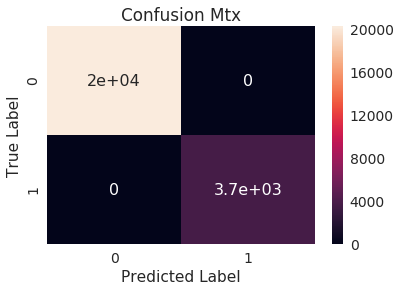

In [37]:
for clf_name in ["LogisticRegression","GBTClassifier", "RandomForestClassifier"]:
    print("\n using PCA features train, test, and visualized results of: {}".format(clf_name))
    train_predict_models(train_pca_df, test_pca_df, clf_name, featuresCol="pcaFeatures",labelCol="label")

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.